# ¿Cuál es la mejor tarifa?

## Introducción

Trabajas como analista para el operador de telecomunicaciones Megaline. La empresa ofrece a sus clientes dos tarifas de prepago, Surf y Ultimate. El departamento comercial quiere saber cuál de las tarifas genera más ingresos para poder ajustar el presupuesto de publicidad.

Vas a realizar un análisis preliminar de las tarifas basado en una selección de clientes relativamente pequeña. Tendrás los datos de 500 clientes de Megaline: quiénes son los clientes, de dónde son, qué tarifa usan, así como la cantidad de llamadas que hicieron y los mensajes de texto que enviaron en 2018. Tu trabajo es analizar el comportamiento de los clientes y determinar qué tarifa de prepago genera más ingresos.

## Inicialización

In [103]:
# Cargar todas las librerías
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math as mt
import scipy.stats as st


## Cargar datos

In [104]:
# Carga los archivos de datos en diferentes DataFrames
users = pd.read_csv('/datasets/megaline_users.csv')
plans = pd.read_csv('/datasets/megaline_plans.csv')
messages = pd.read_csv('/datasets/megaline_messages.csv')
internet = pd.read_csv('/datasets/megaline_internet.csv')
calls = pd.read_csv('/datasets/megaline_calls.csv')

## Preparar los datos

## Tarifas

In [105]:
# Imprime la información general/resumida sobre el DataFrame de las tarifas

plans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


In [106]:
# Imprime una muestra de los datos para las tarifas

plans

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


###### No hay valores ausentes en el Dataframe, lo que es positivo y sugiere que los datos están completos, todos los tipos de datos son adecuado para el tipo de información que representan.

## Corregir datos

## Enriquecer los datos

In [107]:
# Convertimos mb a gb y cambiamos el tipo de columna a int
plans['gb_per_month_included'] = plans['mb_per_month_included'] / 1024
plans['gb_per_month_included'] = plans['gb_per_month_included'].apply(mt.ceil)

plans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
 8   gb_per_month_included  2 non-null      int64  
dtypes: float64(2), int64(6), object(1)
memory usage: 272.0+ bytes


## Usuarios/as

In [108]:
# Imprime la información general/resumida sobre el DataFrame de usuarios

users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [109]:
# Imprime una muestra de datos para usuarios

users.head(10)

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN
5,1005,Livia,Shields,31,"Dallas-Fort Worth-Arlington, TX MSA",2018-11-29,surf,NaN
6,1006,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,ultimate,2018-12-18
7,1007,Eusebio,Welch,42,"Grand Rapids-Kentwood, MI MSA",2018-07-11,surf,NaN
8,1008,Emely,Hoffman,53,"Orlando-Kissimmee-Sanford, FL MSA",2018-08-03,ultimate,NaN
9,1009,Gerry,Little,19,"San Jose-Sunnyvale-Santa Clara, CA MSA",2018-04-22,surf,NaN


###### Las columnas ´reg_date´ y ´churn_date´ están en formato object, lo que no permite operaciones de fecha, la columna ´churn_date´ tienen un número significativo de valores ausentes.

### Corregir los datos

In [110]:
# cambiamos el formato de la columna a datetime
users['reg_date'] = pd.to_datetime(users['reg_date'], format= '%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format= '%Y-%m-%d')
users['churn_date'] = pd.Timestamp('today').normalize()

### Enriquecer los datos

In [111]:
# Cambiamos el nombre de la columna plan a plan_name

users = users.rename(columns={'plan': 'plan_name'})
users

,user_id,first_name,last_name,age,city,reg_date,plan_name,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,2024-10-30
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,2024-10-30
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,2024-10-30
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,2024-10-30
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,2024-10-30
...,...,...,...,...,...,...,...,...
495,1495,Fidel,Sharpe,67,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-09-04,surf,2024-10-30
496,1496,Ariel,Shepherd,49,"New Orleans-Metairie, LA MSA",2018-02-20,surf,2024-10-30
497,1497,Donte,Barrera,49,"Los Angeles-Long Beach-Anaheim, CA MSA",2018-12-10,ultimate,2024-10-30
498,1498,Scot,Williamson,51,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-02-04,surf,2024-10-30


In [112]:
# Imprime la información general/resumida sobre el DataFrame de las llamadas

calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [113]:
# Imprime una muestra de datos para las llamadas

calls.head(10)

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22
5,1000_388,1000,2018-12-31,2.20
6,1000_510,1000,2018-12-27,5.75
7,1000_521,1000,2018-12-28,14.18
8,1000_530,1000,2018-12-28,5.77
9,1000_544,1000,2018-12-26,4.40


###### Todas las columnas tienen el mismo número de datos no nulos por lo que no hay valores ausentes, la columna call_date debería de estar en formato datetime ya que esto permitirá realizar análisis de forma más precisa

### Corregir los datos

In [114]:
# Cambiamos el formato de la columna call_date a datetime
calls['call_date'] = pd.to_datetime(calls['call_date'], format= '%Y-%m-%d')
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  object        
 1   user_id    137735 non-null  int64         
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.2+ MB


### Enriquecer los datos

In [115]:
# Redondeamos hacia arriba el valor de la columna duration
calls['duration'] = np.ceil(calls['duration'])
calls['duration'] = calls['duration'].astype(int)
calls.head(10)

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,9
1,1000_145,1000,2018-12-27,14
2,1000_247,1000,2018-12-27,15
3,1000_309,1000,2018-12-28,6
4,1000_380,1000,2018-12-30,5
5,1000_388,1000,2018-12-31,3
6,1000_510,1000,2018-12-27,6
7,1000_521,1000,2018-12-28,15
8,1000_530,1000,2018-12-28,6
9,1000_544,1000,2018-12-26,5


## Mensajes

In [116]:
# Imprime la información general/resumida sobre el DataFrame de los mensajes

messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [117]:
# Imprime una muestra de datos para los mensajes

messages.head(10)

,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26
5,1000_346,1000,2018-12-29
6,1000_386,1000,2018-12-30
7,1000_413,1000,2018-12-31
8,1000_502,1000,2018-12-27
9,1000_525,1000,2018-12-28


###### El Dataframe tiene 3 columnas: ´id´, ´user_id´ y ´message_date´. El tipo de dato object en message_date sugiere que la columna está en formato de texto y no en un tipo de dato de fecha

### Corregir los datos

In [118]:
# Cambiamos el formato de object a datetime en la columna message_date
messages['message_date'] = pd.to_datetime(messages['message_date'], format= '%Y-%m-%d')
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.7+ MB


### Enriquecer los datos

In [119]:
# Contamos los mensajes totales que mandó cada usuario
messages['message_count_per_user'] = messages.groupby('user_id')['id'].transform('count')
messages

,id,user_id,message_date,message_count_per_user
0,1000_125,1000,2018-12-27,11
1,1000_160,1000,2018-12-31,11
2,1000_223,1000,2018-12-31,11
3,1000_251,1000,2018-12-27,11
4,1000_255,1000,2018-12-26,11
...,...,...,...,...
76046,1497_526,1497,2018-12-24,50
76047,1497_536,1497,2018-12-24,50
76048,1497_547,1497,2018-12-31,50
76049,1497_558,1497,2018-12-24,50


## Internet

In [120]:
# Imprime la información general/resumida sobre el DataFrame de internet

internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [121]:
# Imprime una muestra de datos para el tráfico de internet

internet.head(10)

,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22
5,1001_0,1001,2018-08-24,284.68
6,1001_3,1001,2018-12-09,656.04
7,1001_4,1001,2018-11-04,16.97
8,1001_10,1001,2018-11-27,135.18
9,1001_15,1001,2018-12-13,761.92


###### El Dataframe tiene cuatro columnas: id, user_id, session_date y mb_used. No hay valores nulos en ninguna columna, el tipo de dato object en la columna session_date sugiere que las fechas están almacenadas como texto

### Corregir los datos

In [122]:
# Cambiamos el formato de la columna session_date de object a datetime 
internet['session_date'] = pd.to_datetime(internet['session_date'], format= '%Y-%m-%d')
internet.head(10)

,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22
5,1001_0,1001,2018-08-24,284.68
6,1001_3,1001,2018-12-09,656.04
7,1001_4,1001,2018-11-04,16.97
8,1001_10,1001,2018-11-27,135.18
9,1001_15,1001,2018-12-13,761.92


### Enriquecer los datos

In [123]:
# Agregamos una nueva columna que contiene los mb usados por el usuario en gb
internet['gb_used'] = internet['mb_used'] / 1024
internet.head(10)

,id,user_id,session_date,mb_used,gb_used
0,1000_13,1000,2018-12-29,89.86,0.087754
1,1000_204,1000,2018-12-31,0.00,0.000000
2,1000_379,1000,2018-12-28,660.40,0.644922
3,1000_413,1000,2018-12-26,270.99,0.264639
4,1000_442,1000,2018-12-27,880.22,0.859590
5,1001_0,1001,2018-08-24,284.68,0.278008
6,1001_3,1001,2018-12-09,656.04,0.640664
7,1001_4,1001,2018-11-04,16.97,0.016572
8,1001_10,1001,2018-11-27,135.18,0.132012
9,1001_15,1001,2018-12-13,761.92,0.744062


## Estudiar las condiciones de las tarifas

In [124]:
# Imprime las condiciones de la tarifa y asegúrate de que te quedan claras

plans

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,gb_per_month_included
0,50,15360,500,20,10,0.03,0.03,surf,15
1,1000,30720,3000,70,7,0.01,0.01,ultimate,30


In [125]:
# Calcula el número de llamadas hechas por cada usuario al mes. Guarda el resultado.
calls['month'] = calls['call_date'].dt.to_period('M')
monthly_calls = calls.groupby(['user_id', 'month']).agg(total_calls=('duration', 'count')).reset_index()
monthly_calls

,user_id,month,total_calls
0,1000,2018-12,16
1,1001,2018-08,27
2,1001,2018-09,49
3,1001,2018-10,65
4,1001,2018-11,64
...,...,...,...
2253,1498,2018-12,39
2254,1499,2018-09,41
2255,1499,2018-10,53
2256,1499,2018-11,45


In [126]:
# Calcula la cantidad de minutos usados por cada usuario al mes. Guarda el resultado.
calls['month'] = calls['call_date'].dt.to_period('M')
monthly_minutes = calls.groupby(['user_id', 'month']).agg(total_minutes=('duration', 'sum')).reset_index()
monthly_minutes

,user_id,month,total_minutes
0,1000,2018-12,124
1,1001,2018-08,182
2,1001,2018-09,315
3,1001,2018-10,393
4,1001,2018-11,426
...,...,...,...
2253,1498,2018-12,339
2254,1499,2018-09,346
2255,1499,2018-10,385
2256,1499,2018-11,308


In [127]:
# Calcula el número de mensajes enviados por cada usuario al mes. Guarda el resultado.
messages['month'] = messages['message_date'].dt.to_period('M')
monthly_messages = messages.groupby(['user_id', 'month']).agg(total_messages=('id', 'count')).reset_index()
monthly_messages


,user_id,month,total_messages
0,1000,2018-12,11
1,1001,2018-08,30
2,1001,2018-09,44
3,1001,2018-10,53
4,1001,2018-11,36
...,...,...,...
1801,1496,2018-09,21
1802,1496,2018-10,18
1803,1496,2018-11,13
1804,1496,2018-12,11


In [128]:
# Calcula el volumen del tráfico de Internet usado por cada usuario al mes. Guarda el resultado.
internet['month'] = internet['session_date'].dt.to_period('M')
monthly_traffic = internet.groupby(['user_id', 'month']).agg(total_traffic_gb=('gb_used', 'sum')).reset_index()
monthly_traffic['total_traffic_gb'] = np.ceil(monthly_traffic['total_traffic_gb'])
monthly_traffic['total_traffic_gb'] = monthly_traffic['total_traffic_gb'].astype(int)
monthly_traffic

,user_id,month,total_traffic_gb
0,1000,2018-12,2
1,1001,2018-08,7
2,1001,2018-09,14
3,1001,2018-10,22
4,1001,2018-11,19
...,...,...,...
2272,1498,2018-12,23
2273,1499,2018-09,13
2274,1499,2018-10,20
2275,1499,2018-11,17


[Junta los datos agregados en un DataFrame para que haya un registro que represente lo que consumió un usuario único en un mes determinado.]

In [129]:
# Fusiona los datos de llamadas, minutos, mensajes e Internet con base en user_id y month
data = monthly_calls.merge(monthly_messages, on=['user_id', 'month'], how='left') \
                    .merge(monthly_minutes, on=['user_id', 'month'], how='left') \
                    .merge(monthly_traffic, on=['user_id', 'month'], how='left')

data['total_messages'] = data['total_messages'].fillna(0).astype(int)
data['total_traffic_gb'] = data['total_traffic_gb'].fillna(0).astype(int)
data.head(10)

,user_id,month,total_calls,total_messages,total_minutes,total_traffic_gb
0,1000,2018-12,16,11,124,2
1,1001,2018-08,27,30,182,7
2,1001,2018-09,49,44,315,14
3,1001,2018-10,65,53,393,22
4,1001,2018-11,64,36,426,19
5,1001,2018-12,56,44,412,19
6,1002,2018-10,11,15,59,7
7,1002,2018-11,55,32,386,19
8,1002,2018-12,47,41,384,15
9,1003,2018-12,149,50,1104,27


In [130]:
# Añade la información de la tarifa
users_subset = users[['user_id', 'city', 'plan_name']]
data = data.merge(users_subset, on='user_id')

data = data.merge(plans, on='plan_name', how='left')
data.head(10)

,user_id,month,total_calls,total_messages,total_minutes,total_traffic_gb,city,plan_name,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,gb_per_month_included
0,1000,2018-12,16,11,124,2,"Atlanta-Sandy Springs-Roswell, GA MSA",ultimate,1000,30720,3000,70,7,0.01,0.01,30
1,1001,2018-08,27,30,182,7,"Seattle-Tacoma-Bellevue, WA MSA",surf,50,15360,500,20,10,0.03,0.03,15
2,1001,2018-09,49,44,315,14,"Seattle-Tacoma-Bellevue, WA MSA",surf,50,15360,500,20,10,0.03,0.03,15
3,1001,2018-10,65,53,393,22,"Seattle-Tacoma-Bellevue, WA MSA",surf,50,15360,500,20,10,0.03,0.03,15
4,1001,2018-11,64,36,426,19,"Seattle-Tacoma-Bellevue, WA MSA",surf,50,15360,500,20,10,0.03,0.03,15
5,1001,2018-12,56,44,412,19,"Seattle-Tacoma-Bellevue, WA MSA",surf,50,15360,500,20,10,0.03,0.03,15
6,1002,2018-10,11,15,59,7,"Las Vegas-Henderson-Paradise, NV MSA",surf,50,15360,500,20,10,0.03,0.03,15
7,1002,2018-11,55,32,386,19,"Las Vegas-Henderson-Paradise, NV MSA",surf,50,15360,500,20,10,0.03,0.03,15
8,1002,2018-12,47,41,384,15,"Las Vegas-Henderson-Paradise, NV MSA",surf,50,15360,500,20,10,0.03,0.03,15
9,1003,2018-12,149,50,1104,27,"Tulsa, OK MSA",surf,50,15360,500,20,10,0.03,0.03,15


In [131]:
# Calcula el ingreso mensual para cada usuario

def calculate_revenue(row):
    
    messages_limit = row['messages_included']
    minutes_limit = row['minutes_included']
    data_limit_gb = row['gb_per_month_included']
    
    total_messages = row['total_messages']
    total_minutes = row['total_minutes']
    total_traffic_gb = row['total_traffic_gb']
    
    excess_messages = max(0, total_messages - messages_limit)
    excess_minutes = max(0, total_minutes - minutes_limit)
    excess_data_gb = max(0, total_traffic_gb - data_limit_gb)
    
    additional_message_charge = excess_messages * row['usd_per_message']
    additional_minute_charge = excess_minutes * row['usd_per_minute']
    additional_data_charge = excess_data_gb * row['usd_per_gb']
    
    total_revenue = row['usd_monthly_pay'] + additional_message_charge + additional_minute_charge + additional_data_charge
    return total_revenue

data['monthly_revenue'] = data.apply(calculate_revenue, axis=1)

data.head(10)

,user_id,month,total_calls,total_messages,total_minutes,total_traffic_gb,city,plan_name,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,gb_per_month_included,monthly_revenue
0,1000,2018-12,16,11,124,2,"Atlanta-Sandy Springs-Roswell, GA MSA",ultimate,1000,30720,3000,70,7,0.01,0.01,30,70.00
1,1001,2018-08,27,30,182,7,"Seattle-Tacoma-Bellevue, WA MSA",surf,50,15360,500,20,10,0.03,0.03,15,20.00
2,1001,2018-09,49,44,315,14,"Seattle-Tacoma-Bellevue, WA MSA",surf,50,15360,500,20,10,0.03,0.03,15,20.00
3,1001,2018-10,65,53,393,22,"Seattle-Tacoma-Bellevue, WA MSA",surf,50,15360,500,20,10,0.03,0.03,15,90.09
4,1001,2018-11,64,36,426,19,"Seattle-Tacoma-Bellevue, WA MSA",surf,50,15360,500,20,10,0.03,0.03,15,60.00
5,1001,2018-12,56,44,412,19,"Seattle-Tacoma-Bellevue, WA MSA",surf,50,15360,500,20,10,0.03,0.03,15,60.00
6,1002,2018-10,11,15,59,7,"Las Vegas-Henderson-Paradise, NV MSA",surf,50,15360,500,20,10,0.03,0.03,15,20.00
7,1002,2018-11,55,32,386,19,"Las Vegas-Henderson-Paradise, NV MSA",surf,50,15360,500,20,10,0.03,0.03,15,60.00
8,1002,2018-12,47,41,384,15,"Las Vegas-Henderson-Paradise, NV MSA",surf,50,15360,500,20,10,0.03,0.03,15,20.00
9,1003,2018-12,149,50,1104,27,"Tulsa, OK MSA",surf,50,15360,500,20,10,0.03,0.03,15,158.12


## Estudia el comportamiento de usuario

### Llamadas

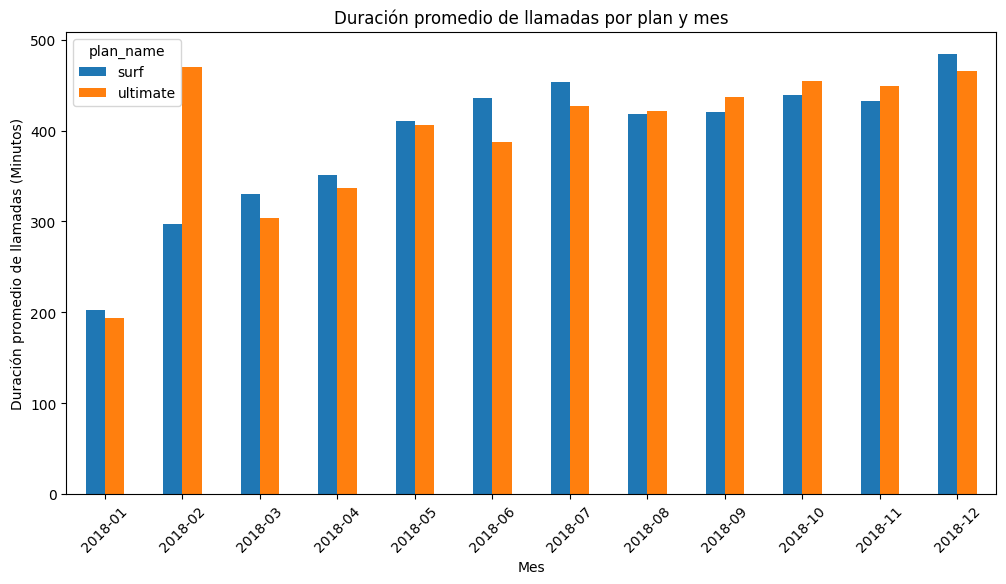

In [132]:
# Compara la duración promedio de llamadas por cada plan y por cada mes. Traza un gráfico de barras para visualizarla.
duration_calls_mean = data.groupby(['month', 'plan_name'])['total_minutes'].mean().reset_index()
duration_calls_mean.pivot(index='month', columns='plan_name', values='total_minutes').plot(kind='bar',
                                                                                           figsize=(12, 6),
                                                                                           title='Duración promedio de llamadas por plan y mes',
                                                                                           xlabel='Mes',
                                                                                           rot=45,
                                                                                           ylabel='Duración promedio de llamadas (Minutos)')
plt.show()

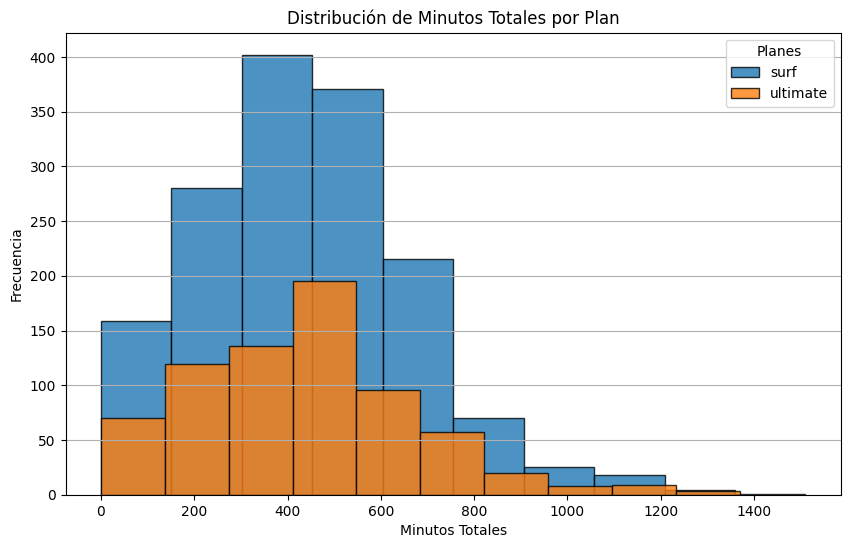

In [133]:
# Compara el número de minutos mensuales que necesitan los usuarios de cada plan. Traza un histograma.

min_user = data.groupby('plan_name')['total_minutes']

plt.figure(figsize=(10, 6))
min_user.plot(kind='hist', bins=10, edgecolor='black', alpha=0.80)
plt.title('Distribución de Minutos Totales por Plan')
plt.xlabel('Minutos Totales')
plt.ylabel('Frecuencia')
plt.grid(axis='y')
plt.legend(title='Planes')
plt.show()

[Calcula la media y la variable de la duración de las llamadas para averiguar si los usuarios de los distintos planes se comportan de forma diferente al realizar sus llamadas.]

In [134]:
monthly_call_stats = data.groupby('plan_name')['total_minutes'].agg(['mean', 'var']).reset_index()

monthly_call_stats.columns = ['plan_name', 'mean_duration', 'variance_duration']

monthly_call_stats

,plan_name,mean_duration,variance_duration
0,surf,436.519741,52571.063243
1,ultimate,434.676017,56573.632247


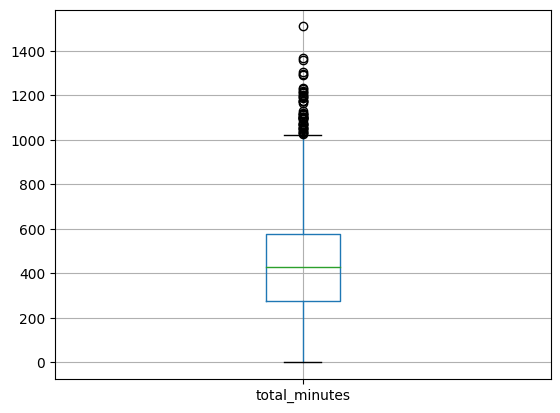

In [135]:
# Traza un diagrama de caja para visualizar la distribución de la duración mensual de llamadas

calls_distribution = data.boxplot(column='total_minutes')
plt.show()

###### La diferencia de la duración promedio es muy pequeña, lo cual sugiere que en términos generales, los usuarios de ambos planes realizan llamadas de duración muy similar. Ultimate tiene una varianza un  poco mayor, lo que podría sugerir que los usuarios de este plan tienen mayor variabilidad en la duración de sus llamadas.

### Mensajes

In [136]:
# Comprara el número de mensajes que tienden a enviar cada mes los usuarios de cada plan
monthly_message_stats = data.groupby('plan_name')['total_messages'].agg(['mean', 'var']).reset_index()

# Renombramos las columnas para mayor claridad
monthly_message_stats.columns = ['plan_name', 'mean_duration', 'variance_duration']

monthly_message_stats

,plan_name,mean_duration,variance_duration
0,surf,30.897735,1131.949380
1,ultimate,37.725105,1210.143428


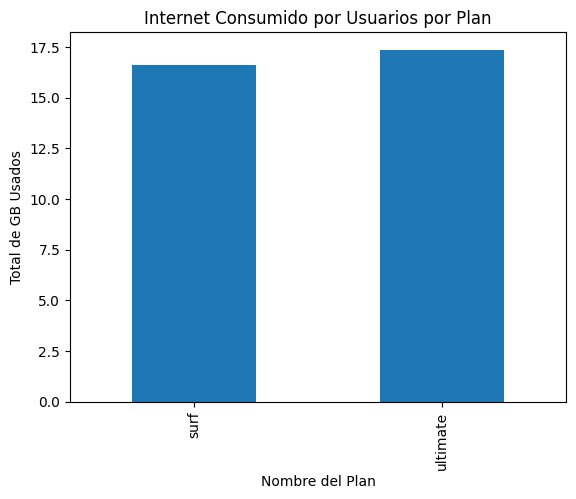

In [137]:
# Compara la cantidad de tráfico de Internet consumido por usuarios por plan

traffic_internet = data.groupby('plan_name')['total_traffic_gb'].mean()

traffic_internet.plot(kind='bar',
                      title='Internet Consumido por Usuarios por Plan',
                      xlabel='Nombre del Plan',
                      ylabel='Total de GB Usados',
                      )
plt.show()

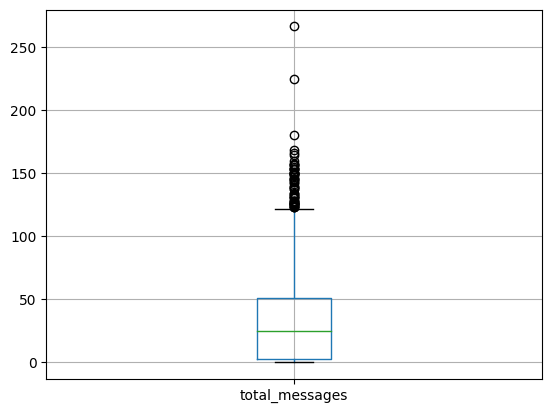

In [138]:
calls_distribution = data.boxplot(column='total_messages')
plt.show()

###### Los usuarios del plan Ultimate envían en promedio más mensajes que los usuarios del plan Surf, esto sugiere que en promedio los usuarios Ultimate tienden a usar el servicio de mensajería más que los usuarios de Surf.

### Internet

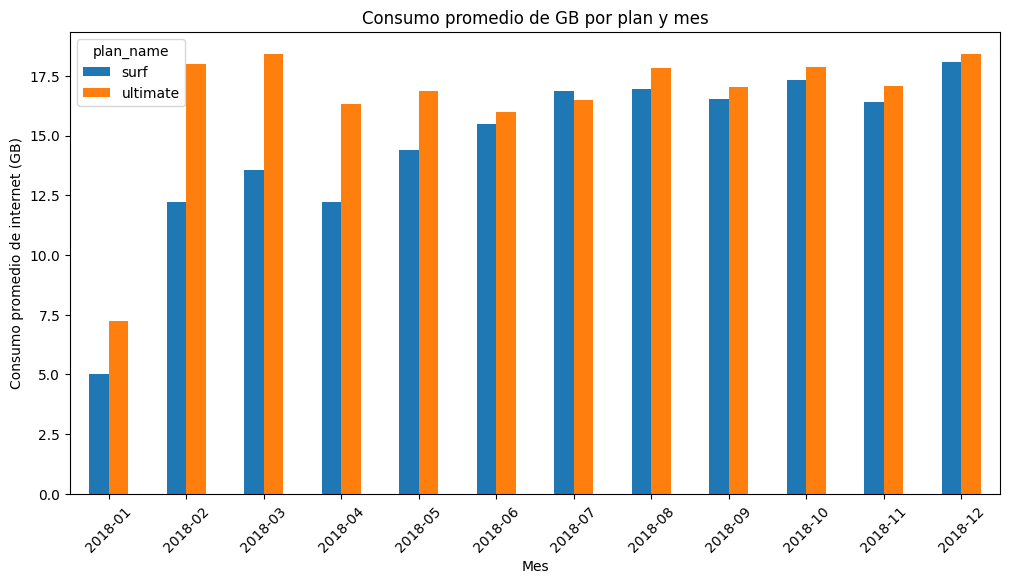

In [139]:
traffic_gb_bar = data.groupby(['month', 'plan_name'])['total_traffic_gb'].mean().reset_index()
traffic_gb_bar.pivot(index='month', columns='plan_name', values='total_traffic_gb').plot(kind='bar',
                                                                                           figsize=(12, 6),
                                                                                           title='Consumo promedio de GB por plan y mes',
                                                                                           xlabel='Mes',
                                                                                           rot=45,
                                                                                           ylabel='Consumo promedio de internet (GB)')
plt.show()

In [140]:
traffic_internet = data.groupby('plan_name')['total_traffic_gb'].mean().reset_index()

traffic_internet.columns = ['plan_name', 'total_traffic_gb']

traffic_internet

,plan_name,total_traffic_gb
0,surf,16.620065
1,ultimate,17.370266


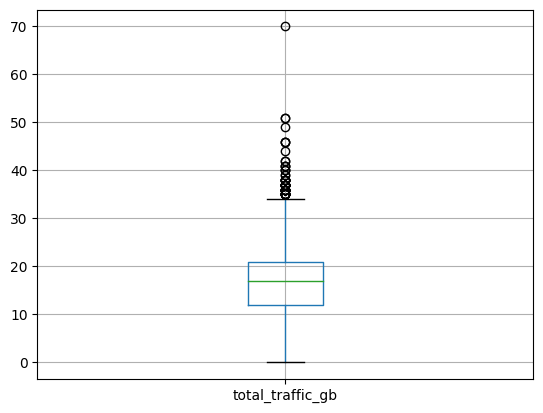

In [141]:
traffic_distribution = data.boxplot(column='total_traffic_gb')
plt.show()

###### La diferencia, aunque no muy marcada, sugiere que los usuarios de Ultimate podrían estar aprovechando más su acceso a datos, posiblemente por la inclusión de un mayor volumne de datos en el plan o por mayores beneficios en cuanto a costo por GB

## Ingreso

[Del mismo modo que has estudiado el comportamiento de los usuarios, describe estadísticamente los ingresos de los planes.]

In [142]:
revenue_mean = data.groupby('plan_name')['monthly_revenue'].mean().reset_index()

revenue_mean.columns = ['plan_name', 'monthly_revenue']

revenue_mean

,plan_name,monthly_revenue
0,surf,60.125515
1,ultimate,72.277700


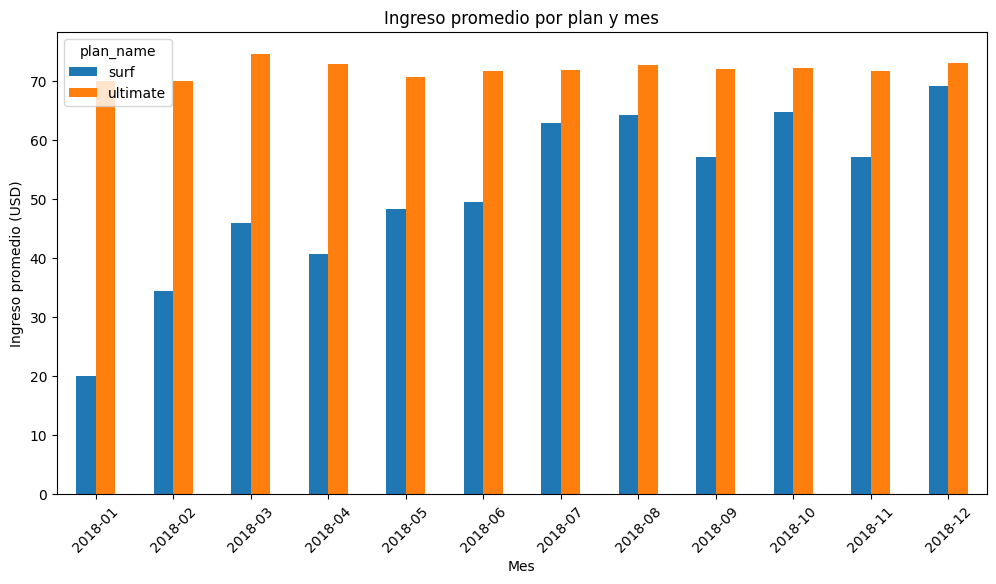

In [143]:
month_revenue = data.groupby(['month', 'plan_name'])['monthly_revenue'].mean().reset_index()
month_revenue.pivot(index='month', columns='plan_name', values='monthly_revenue').plot(kind='bar',
                                                                                           figsize=(12, 6),
                                                                                           title='Ingreso promedio por plan y mes',
                                                                                           xlabel='Mes',
                                                                                           rot=45,
                                                                                           ylabel='Ingreso promedio (USD)')
plt.show()

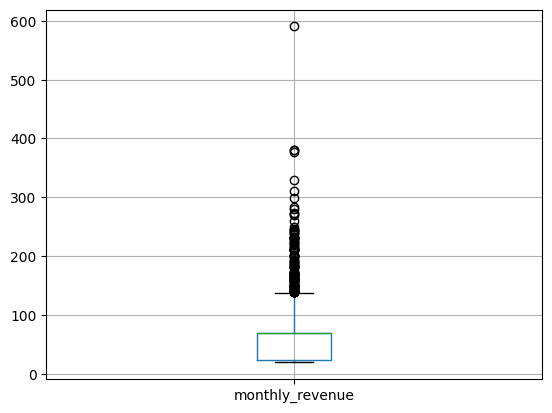

In [144]:
renenue_distribution = data.boxplot(column='monthly_revenue')
plt.show()

###### Los usuarios del plan Ultimate generan un ingreso promedio mensual superior al de los usuarios del plan Surf. Lo cual podría indicar que este plan atrae a usuarios con necesidades de consumo más altas o dispuestos a pagar más por un servicio con mayores beneficios. Esto podría sugerir que el plan Ultimate es más rentable para la empresa, ya que genera ingresos más altos por usuario.

## Prueba las hipótesis estadísticas

In [145]:
# Prueba las hipótesis

ultimate_revenues = data[data['plan_name'] == 'ultimate']['monthly_revenue']
surf_revenues = data[data['plan_name'] == 'surf']['monthly_revenue']

result = st.ttest_ind(ultimate_revenues, surf_revenues, equal_var=False)

alpha = 0.05

print("Valor p:", result.pvalue)

if result.pvalue < alpha:
    print("Rechazamos la hipótesis nula: existe una diferencia significativa en los ingresos promedio.")
else:
    print('No rechazamos la hipótesis nula: no hay evidencia suficiente para afirmar que los ingresos promedio son diferentes.')


Valor p: 3.363644868810144e-17
Rechazamos la hipótesis nula: existe una diferencia significativa en los ingresos promedio.


In [146]:
# Prueba las hipótesis
ny_nj_income = data[data['city'] == 'New York-Newark-Jersey City, NY-NJ-PA MSA']['monthly_revenue']
other_income = data[data['city'] != 'New York-Newark-Jersey City, NY-NJ-PA MSA']['monthly_revenue']

# realizamos la prueba t
result = st.ttest_ind(ny_nj_income, other_income, equal_var=False)

alpha = 0.05

# imprimimos el valor p
print("Valor p:", result.pvalue)

# tomamos la decisión basada en el valor p
if result.pvalue < alpha:
    print('Rechazamos la hipótesis nula: hay una diferencia significativa en los ingresos promedio')
else:
    print("No se rechaza la hipótesis nula: no hay una diferencia significativa en los ingresos promedio.")

Valor p: 0.013118130086619653
Rechazamos la hipótesis nula: hay una diferencia significativa en los ingresos promedio


## Conclusión general

En este análisis, se encontraron diferencias notables en el comportamiento de los usuarios de los planes Surf y Ultimate. Aunque la duración promedio de las llamadas es similar en ambos planes, los usuarios de Ultimate tienden a enviar más mensajes y utilizar una cantidad ligeramente mayor de datos, lo que sugiere que tienen un uso más intensivo de los servicios. Además, el ingreso promedio mensual de los usuarios de Ultimate es más alto que el de Surf.

Estos resultados indican que los usuarios del plan Ultimate podrían valorar más la variedad y el uso intensivo de los servicios que se ofrecen. Esta información es útil para tomar decisiones sobre posibles mejoras en los planes, como ajustar las características o los precios, para satisfacer mejor las necesidades de los diferentes grupos de usuarios. En general, entender el comportamiento de los usuarios ayuda a optimizar la oferta y aumentar la satisfacción del cliente.